In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from MODULES.utilities import load_obj
import torch
import numpy as np
from scipy.sparse import coo_matrix
import networkx as nx
import community as community_louvain
import skimage.color

#!pip install python-louvain

### Load the multichannel segmentation mask

In [5]:
mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/merfish_june22_v2/seg_mask_multichannels.pkl"

integer_seg_mask = load_obj(mask_file)
print(integer_seg_mask.shape)

torch.Size([16, 500, 500])


### Segmentation Mask produced with Sliding window has boundary effect

In [6]:
n_cells = torch.max(integer_seg_mask.flatten(start_dim=1),dim=-1)[0]
print(n_cells)

tensor([430, 423, 404, 393, 423, 417, 398, 393, 425, 414, 394, 393, 405, 403,
        393, 379])


Text(0.5, 1.0, 'different segmentation')

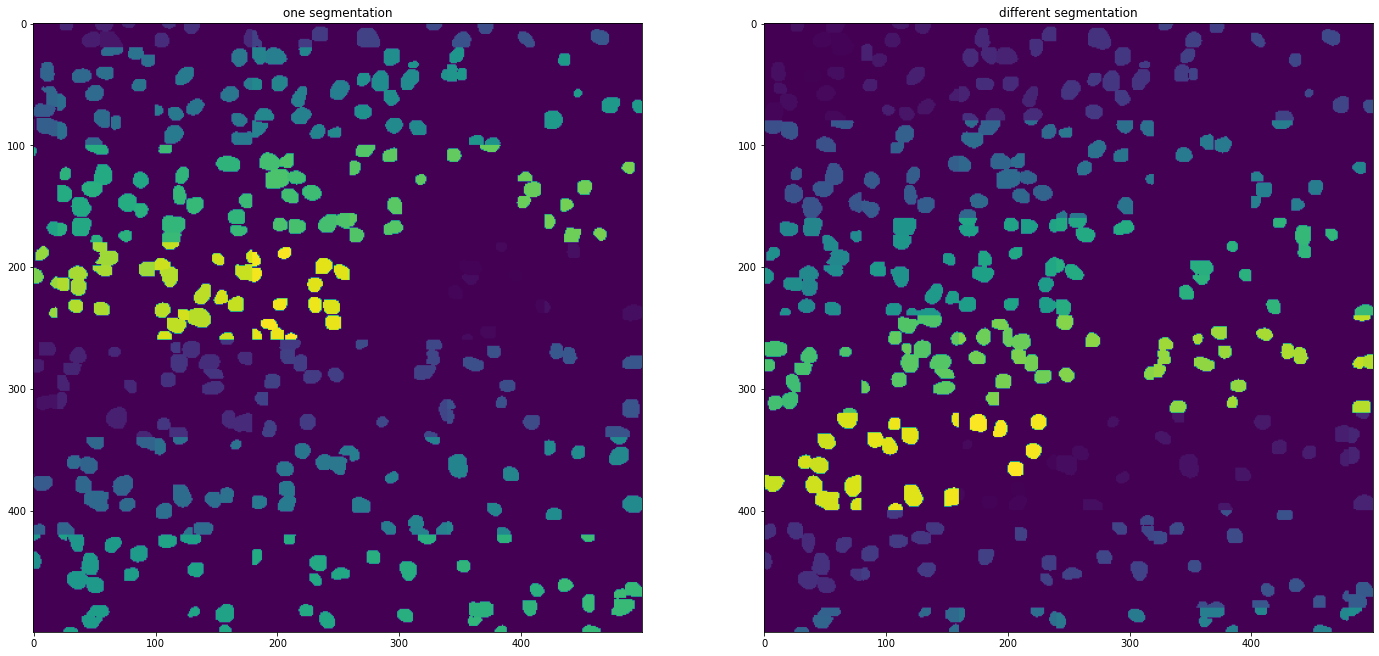

In [9]:
figure, axes = plt.subplots(ncols=2, figsize=(24, 24))
axes[0].imshow((integer_seg_mask[0] % 255).cpu())
axes[1].imshow((integer_seg_mask[-1] % 255).cpu())
axes[0].set_title("one segmentation")
axes[1].set_title("different segmentation")

### Zoomed version

Text(0.5, 1.0, 'different segmentation')

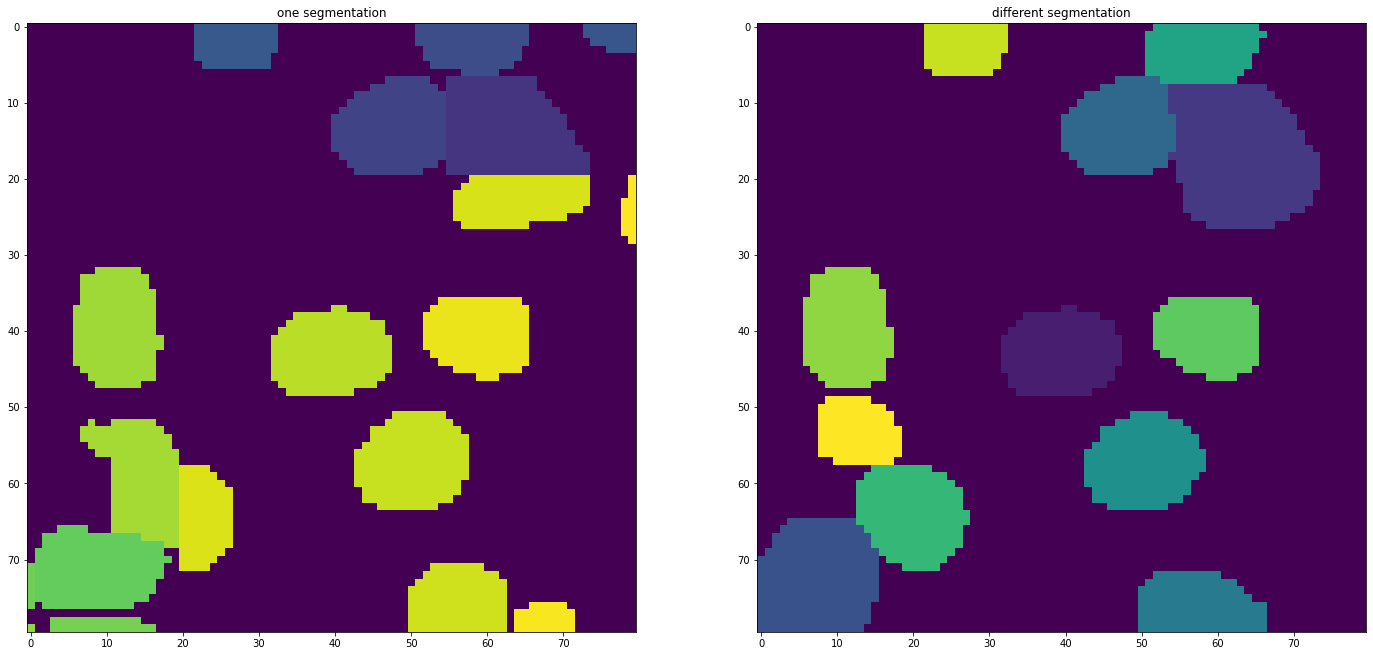

In [11]:
figure, axes = plt.subplots(ncols=2, figsize=(24, 24))
axes[0].imshow((integer_seg_mask[0,:80,:80] % 255).cpu())
axes[1].imshow((integer_seg_mask[-1,:80,:80] % 255).cpu())
axes[0].set_title("one segmentation")
axes[1].set_title("different segmentation")

### Here I do the geraph cutting, i.e. consensus segmentation

In [12]:
class Cluster():
    """ Takes an integer segmentation mask and produce a graph. 
        Each pixel belonging to the fg is a node. 
        The edge is the number of times pixels appear in the same object
        
        Typical usage:
        c = Cluster(pixel_features)
        m = c.clusters
        print(m.shape)
        show_batch(m)
        pixel_feature has size: batch x ch x width x height
    """
    
    def __init__(self, integer_mask):
        super().__init__()
        
        # size = ch, w, h. Contains the labels bg=0, fg= 1,2,...
        assert len(integer_mask.shape) == 3 
        
        self.ch, self.nx, self.ny = integer_mask.shape
        self.integer_mask = integer_mask
        self.fg_mask = (torch.sum(integer_mask, dim=-3) > 0)
        self.n_fg_pixel = torch.sum(self.fg_mask).item()
        self.index_matrix = (torch.cumsum(self.fg_mask.view(-1), dim=-1).view_as(self.fg_mask) -1) * self.fg_mask
        print("n_fg_pixel",self.n_fg_pixel)
        
    @property
    def S_NN(self):
        try:
            return self.similarity_NN
        except AttributeError:
            self.similarity_NN = None
        
            # Build the Nearest Neightbor graph. I can change the radius
            d_max = 1
            for dx in range(-d_max,d_max+1):
                index_tmp = torch.roll(self.index_matrix, dx, dims=-2)
                mask_tmp = torch.roll(self.integer_mask, dx, dims=-2)
                for dy in range(-d_max,d_max+1):
                    index_shifted = torch.roll(index_tmp, dy, dims=-1)
                    mask_shifted = torch.roll(mask_tmp, dy, dims=-1)
                    if(dx==0 and dy==0):
                        continue
                    else:
                        edge = torch.sum(self.integer_mask == mask_shifted, dim=-3)
                        
                        i_tmp= self.index_matrix[self.fg_mask]
                        j_tmp = index_shifted[self.fg_mask]
                        v_tmp = edge[self.fg_mask]
                        
                        select = (v_tmp > 0)
                        i = i_tmp[select].numpy()
                        j = j_tmp[select].numpy()
                        v = v_tmp[select].numpy()
                        
                        M = coo_matrix((v, (i, j)), dtype='int', shape=(self.n_fg_pixel,self.n_fg_pixel))
                        
                        if self.similarity_NN is None:
                            self.similarity_NN = M  
                        else:
                            self.similarity_NN += M

            return self.similarity_NN
     
    def consensus_mask(self, resolution=1.0, randomize=True):
        a_tmp = self.index_matrix[self.fg_mask].numpy()
        b_tmp = self.integer_mask[0,self.fg_mask].numpy()
        initial_partition = None # dict(zip(a,b))


        graph = nx.from_scipy_sparse_matrix(self.S_NN)
        partition = community_louvain.best_partition(graph, 
                                                     partition=initial_partition,
                                                     resolution=resolution, 
                                                     randomize=randomize)
                    
        index = torch.tensor(list(partition.keys()))
        instance_ID = torch.tensor(list(partition.values()))+1
        print(index)
        print(instance_ID)

        # TODO: this is slow. Make it faster....
        consensus_mask = self.index_matrix.clone()
        for k,v in partition.items():
            consensus_mask[consensus_mask==k]=v
        return consensus_mask
    
c = Cluster(integer_seg_mask)

n_fg_pixel 45302


### RESULT 1: resolution=1

In [13]:
large0 = c.integer_mask[0]
large1 = c.integer_mask[-1]
large2 = c.consensus_mask(resolution=1.0)

tensor([    0,     1,     2,  ..., 45299, 45300, 45301])
tensor([  1,   2,   2,  ..., 248,   1,   1])


430 379 248


Text(0.5, 1.0, 'consensus segmentation. cells=248')

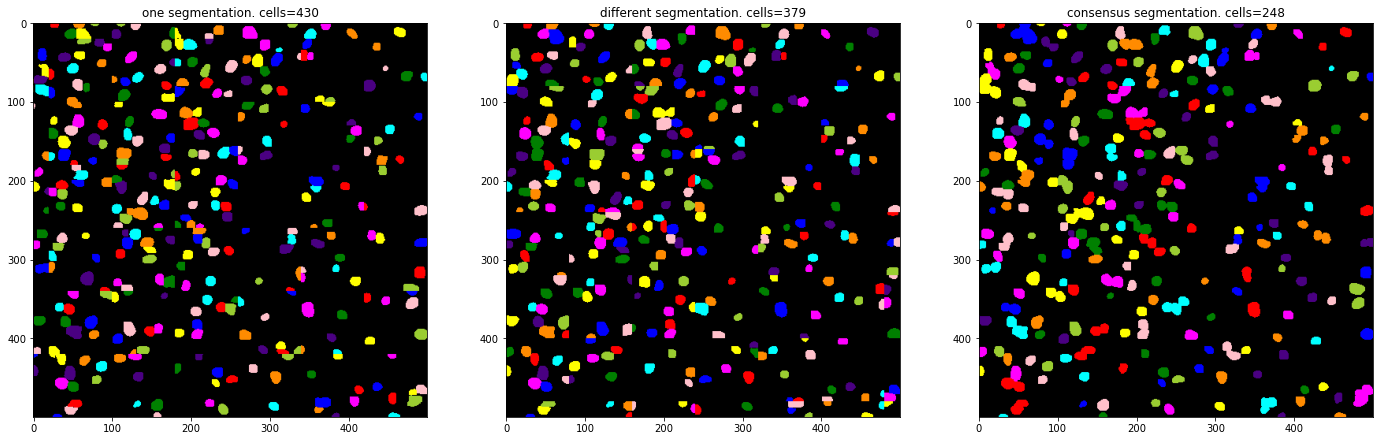

In [15]:
n0 = torch.max(large0).item()
n1 = torch.max(large1).item()
n2 = torch.max(large2).item()
print(n0,n1,n2)

figure, axes = plt.subplots(ncols=3, figsize=(24, 24))
axes[0].imshow(skimage.color.label2rgb(large0.numpy()%255, torch.zeros_like(large0).numpy(), alpha=1, bg_label=0))
axes[1].imshow(skimage.color.label2rgb(large1.numpy()%255, torch.zeros_like(large1).numpy(), alpha=1, bg_label=0))
axes[2].imshow(skimage.color.label2rgb(large2.numpy()%255, torch.zeros_like(large2).numpy(), alpha=1, bg_label=0))
axes[0].set_title("one segmentation. cells="+str(n0))
axes[1].set_title("different segmentation. cells="+str(n1))
axes[2].set_title("consensus segmentation. cells="+str(n2))

### ZOOMED RESULT 1: resolution=1

Text(0.5, 1.0, 'consensus segmentation')

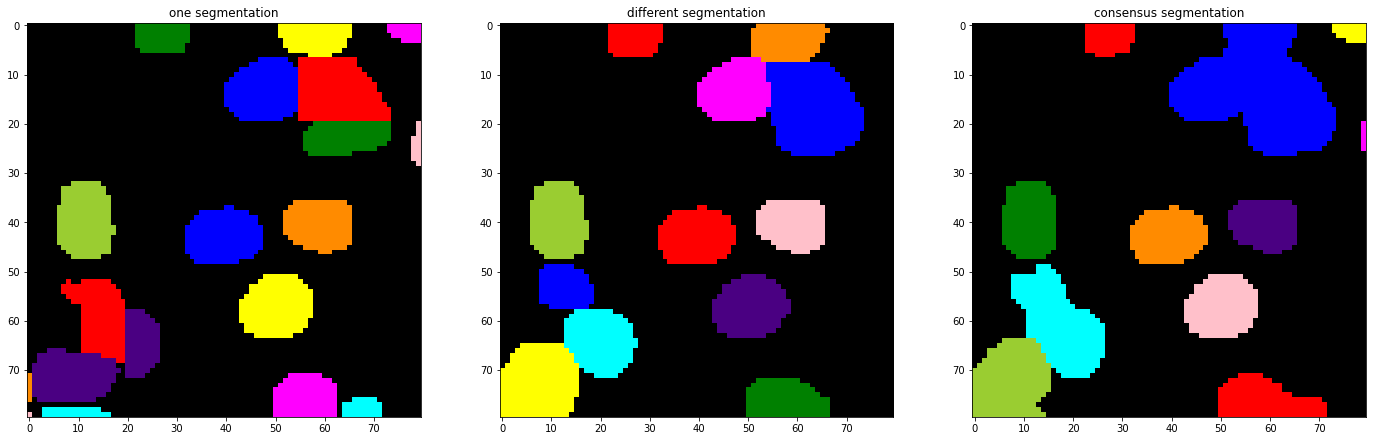

In [16]:
small0 = large0[:80,:80]
small1 = large1[:80,:80]
small2 = large2[:80,:80]

figure, axes = plt.subplots(ncols=3, figsize=(24, 24))
axes[0].imshow(skimage.color.label2rgb(small0.numpy()%255, torch.zeros_like(small0).numpy(), alpha=1, bg_label=0))
axes[1].imshow(skimage.color.label2rgb(small1.numpy()%255, torch.zeros_like(small1).numpy(), alpha=1, bg_label=0))
axes[2].imshow(skimage.color.label2rgb(small2.numpy()%255, torch.zeros_like(small2).numpy(), alpha=1, bg_label=0))
axes[0].set_title("one segmentation")
axes[1].set_title("different segmentation")
axes[2].set_title("consensus segmentation")

### RESULT 2: resolution=0.1

In [20]:
large0 = c.integer_mask[0]
large1 = c.integer_mask[-1]
large2 = c.consensus_mask(resolution=0.1)

tensor([    0,     1,     2,  ..., 45299, 45300, 45301])
tensor([  1,   2,   2,  ..., 303, 303, 303])


430 379 303


Text(0.5, 1.0, 'consensus segmentation. cells=303')

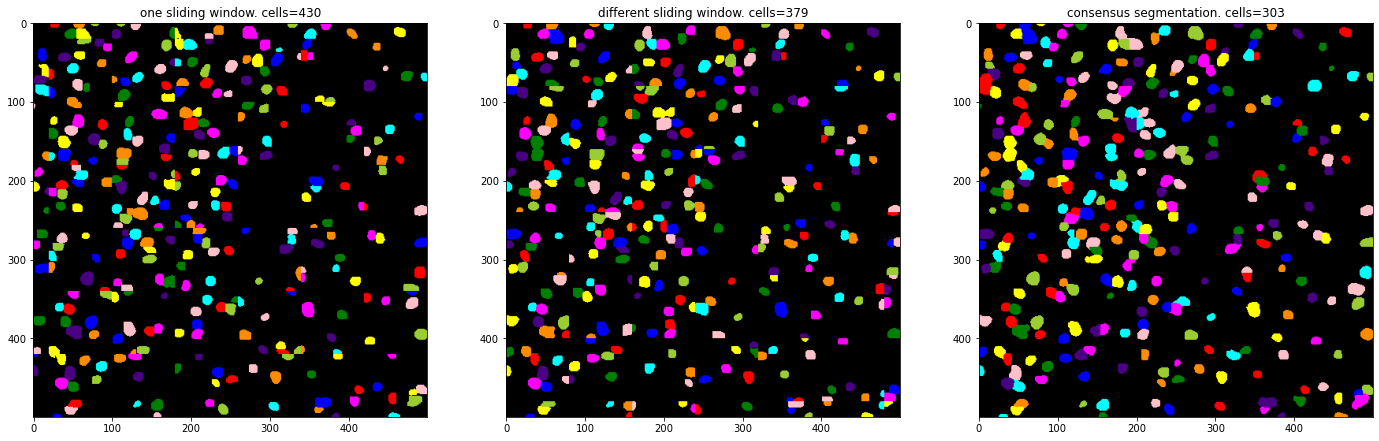

In [21]:
n0 = torch.max(large0).item()
n1 = torch.max(large1).item()
n2 = torch.max(large2).item()
print(n0,n1,n2)

figure, axes = plt.subplots(ncols=3, figsize=(24, 24))
axes[0].imshow(skimage.color.label2rgb(large0.numpy()%255, torch.zeros_like(large0).numpy(), alpha=1, bg_label=0))
axes[1].imshow(skimage.color.label2rgb(large1.numpy()%255, torch.zeros_like(large1).numpy(), alpha=1, bg_label=0))
axes[2].imshow(skimage.color.label2rgb(large2.numpy()%255, torch.zeros_like(large2).numpy(), alpha=1, bg_label=0))
axes[0].set_title("one sliding window. cells="+str(n0))
axes[1].set_title("different sliding window. cells="+str(n1))
axes[2].set_title("consensus segmentation. cells="+str(n2))

### ZOOMED RESULT 2: resolution=0.1

Text(0.5, 1.0, 'consensus segmentation')

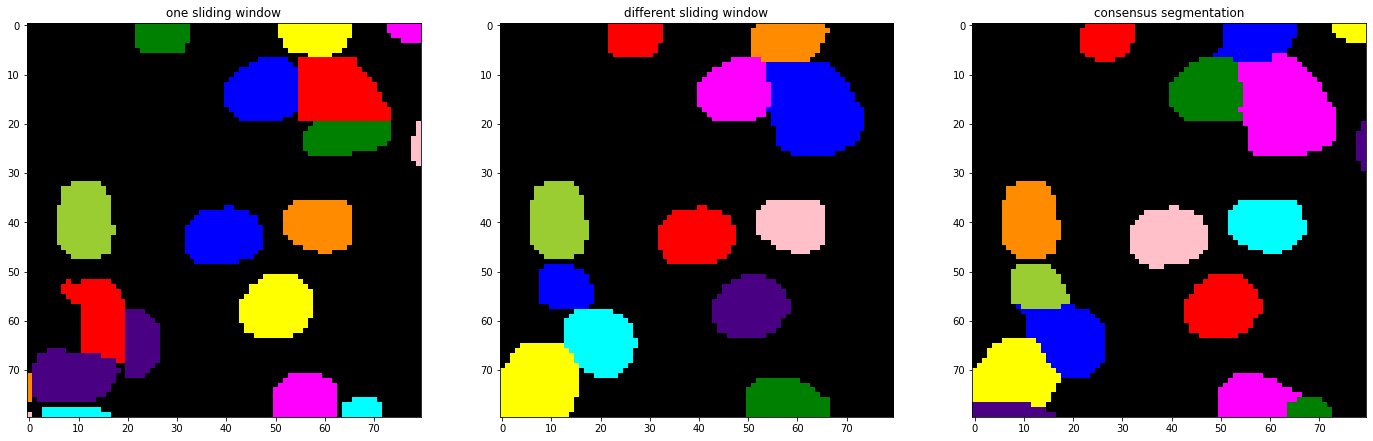

In [22]:
import skimage.color

small0 = large0[:80,:80]
small1 = large1[:80,:80]
small2 = large2[:80,:80]

figure, axes = plt.subplots(ncols=3, figsize=(24, 24))
axes[0].imshow(skimage.color.label2rgb(small0.numpy()%255, torch.zeros_like(small0).numpy(), alpha=1, bg_label=0))
axes[1].imshow(skimage.color.label2rgb(small1.numpy()%255, torch.zeros_like(small1).numpy(), alpha=1, bg_label=0))
axes[2].imshow(skimage.color.label2rgb(small2.numpy()%255, torch.zeros_like(small2).numpy(), alpha=1, bg_label=0))
axes[0].set_title("one sliding window")
axes[1].set_title("different sliding window")
axes[2].set_title("consensus segmentation")